In [1]:
import pathlib as pl
import requests

def download_file(dst_path: pl.Path, url: str):
    res = requests.get(url)
    if not res.status_code == 200:
        raise ValueError(f"Failed to download data - Status code:", res.status_code)

    content = res.content
    with open(dst_path, "wb") as f:
        f.write(content)
    

base_data_path = pl.Path('./data/')
tiny_data_url = "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
tiny_data_name = "tiny_nerf_data.npz"

tiny_data_path = base_data_path / tiny_data_name
if not tiny_data_path.exists():
    download_file(tiny_data_path, tiny_data_url)

Data overview
	Image shape: ((106, 100, 100, 3))
	Poses shape: ((106, 4, 4))
	Focal value: 138.889
	Image range: ((0.0, 1.0))
Pose:
[[ 0.689  0.534 -0.49  -1.975]
 [-0.724  0.508 -0.466 -1.879]
 [ 0.     0.676  0.737  2.97 ]
 [ 0.     0.     0.     1.   ]]


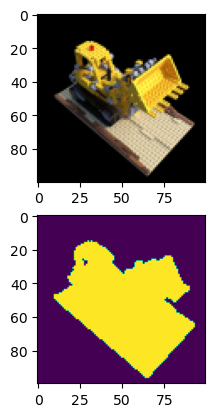

In [2]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load(tiny_data_path)
imgs = data["images"]
poses = data["poses"]
focal = data["focal"]

H, W = imgs.shape[1:3]

print("=" * 50)
print("Data overview")
print(f"\tImage shape: ({imgs.shape})")
print(f"\tPoses shape: ({poses.shape})")
print(f"\tFocal value: {focal:.3f}")
print(f"\tImage range: ({imgs.min(), imgs.max()})")

i_ref = 101
ref_img = imgs[i_ref]
ref_pose = poses[i_ref]
ref_cls = (imgs[i_ref].sum(axis=-1)>0).astype(np.float32)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(ref_img)
ax2.imshow(ref_cls)
print("=" * 50)
print("Pose:")
print(np.round(ref_pose, 3))


In [3]:
import torch
from torch import nn


class TinyNeRF(nn.Module):
    def __init__(self, name: str, L1, n_hidden, act_func=nn.ReLU):
        super().__init__()

        self.name = name

        self.d1 = 6 * L1 + 3

        self.pre_stack = nn.Sequential(
            nn.Linear(self.d1, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
        )

        self.post_stack = nn.Sequential(
            nn.Linear(n_hidden + self.d1, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, 4),
        )


    def forward(
        self, o: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.pre_stack(o)
        x = torch.cat((o, x), dim=-1)
        y = self.post_stack(x)

        return y


class TinyNeRFSeg(nn.Module):
    def __init__(self, name: str, L1, n_hidden, act_func=nn.ReLU):
        super().__init__()

        self.name = name

        self.d1 = 6 * L1 + 3

        self.pre_stack = nn.Sequential(
            nn.Linear(self.d1, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
        )

        self.post_stack = nn.Sequential(
            nn.Linear(n_hidden + self.d1, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, 5),
        )


    def forward(
        self, o: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.pre_stack(o)
        x = torch.cat((o, x), dim=-1)
        y = self.post_stack(x)

        return y

In [4]:
import torchvision


@torch.jit.script
def pos_enc(x: torch.Tensor, L: int) -> torch.Tensor:
    # TODO: Optimimze
    rets = [x]
    for i in range(L):
        rets.append(torch.sin(2.**i * x))
        rets.append(torch.cos(2.**i * x))

    return torch.cat(rets, -1)


@torch.jit.script
def get_rays(
    H: int, W: int, focal: float, c2w: torch.Tensor, device: torch.device
) -> tuple[torch.Tensor, torch.Tensor]:
    x = torch.arange(W, dtype=torch.float32, device=device)
    y = torch.arange(H, dtype=torch.float32, device=device)
    i, j = torch.meshgrid(x, y, indexing="xy")
    dirs = torch.stack(
        ((i - W * 0.5) / focal, -(j - H * 0.5) / focal, -torch.ones_like(i)), dim=-1
    )
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
    rays_o = c2w[:3, -1].broadcast_to(rays_d.shape).clone()

    return rays_o, rays_d


@torch.jit.script
def exclusive_cumprod(x: torch.Tensor) -> torch.Tensor:
    x = torch.cumprod(x, -1)
    x = x.roll(1)
    x[..., 0] = 1
    return x


def render_rays(
    model: nn.Module,
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    t_near: float,
    t_far: float,
    n_samples: int,
    L: int,
    chunk_size: int,
    device: torch.device,
    stratified_sampling: bool = False,
):
    t = (
        torch.linspace(t_near, t_far, n_samples, device=device)
        .broadcast_to([*rays_o.shape[:-1], n_samples])
        .clone()
    )
    if stratified_sampling:
        scalar = (t_far - t_near) / n_samples
        offsets = torch.rand([*rays_o.shape[:-1], n_samples], device=device)
        t += offsets * scalar

    pts = rays_o[..., None, :] + rays_d[..., None, :] * t[..., :, None]

    x = pts.reshape(-1, 3)
    x = pos_enc(x, L)

    ys = [model(x[i : i + chunk_size]) for i in range(0, x.size(0), chunk_size)]
    y = torch.cat(tuple(ys), dim=0).reshape([*pts.shape[:-1], ys[0].size(-1)])

    rgb = y[..., :3]
    sigma = y[..., 3]
    cls_p = y[..., 4]
    rgb = nn.functional.sigmoid(rgb)
    sigma = nn.functional.relu(sigma)
    cls_p = nn.functional.sigmoid(cls_p)

    delta = torch.diff(
        t,
        dim=-1,
        append=1e10 * torch.ones(t[..., :1].shape, device=device, dtype=torch.float32),
    )
    sigma_delta = torch.exp(-sigma * delta)

    w = (1. - sigma_delta) * exclusive_cumprod(sigma_delta + 1e-10)

    rgb_map = torch.sum(w[..., None] * rgb, -2)
    depth_map = torch.sum(w * t, -1)
    cls_map = torch.sum(w * cls_p, -1)

    PRINT_STACK = False
    if PRINT_STACK:
        print("sigma mean", sigma.mean())
        print("delta mean", delta.mean())
        print("sigma delta mean", sigma_delta.mean())
        print("sigma delta mean", sigma_delta.mean())
        print("w mean", w.mean())
        print("rgb mean", rgb.mean())
        print()

    return rgb_map, depth_map, cls_map


def save_rgb_tensor_as_img(x: torch.Tensor, path: pl.Path):
    x = x.detach().cpu().permute(2, 0, 1)
    im = torchvision.transforms.ToPILImage("RGB")(x)
    im.save(path)


def save_mono_tensor_as_img(x: torch.Tensor, path: pl.Path):
    x = x.detach().cpu()
    im = torchvision.transforms.ToPILImage()(x)
    im.save(path)

In [5]:
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
n_samples = 64
n_hidden = 256
L1 = 6
lr = 3e-4
n_data = len(imgs)
chunk_size = 4096

n_iter = 1000
t_near = 2.0
t_far = 6.0
use_stratified_sampling = True

save_freq = 50


model_name = "tiny-nerf-seg"
model = TinyNeRFSeg(model_name, L1=L1, n_hidden=n_hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

base_model_path = pl.Path('./models')
model_path = base_model_path / model.name
model_path.mkdir(parents=True, exist_ok=True)


In [6]:
import time

TRAIN_MODEL = False
if TRAIN_MODEL:
    version = len(list(model_path.iterdir()))
    version_path = model_path / f"version-{version}"
    version_path.mkdir(exist_ok=False)

    ref_path = version_path / "ref"
    ref_path.mkdir()
    save_rgb_tensor_as_img(torch.from_numpy(ref_img), ref_path / f"rgb.png")
    save_mono_tensor_as_img(torch.from_numpy(ref_cls), ref_path / f"cls.png")

    if version_path.exists():
        shutil.rmtree(version_path)

    if not version_path.exists():
        version_path.mkdir()

    prev_time = time.time()
    for epoch in range(n_iter + 1):
        optim.zero_grad()
        i = np.random.randint(n_data)

        model.train()
        rgb_gt = torch.from_numpy(imgs[i]).to(device)
        pose = torch.from_numpy(poses[i]).to(device)
        rays_o, rays_d = get_rays(H, W, focal, pose, device=device)
        rgb, depth, cls = render_rays(
            model,
            rays_o,
            rays_d,
            t_near,
            t_far,
            n_samples,
            L1,
            chunk_size,
            device=device,
            stratified_sampling=use_stratified_sampling,
        )

        seg_cls = (rgb_gt.sum(dim=-1) > 0).float()      # The background is pitch black, so this is all we need to discriminate

        loss_rgb = nn.functional.mse_loss(rgb, rgb_gt)
        loss_cls = nn.functional.binary_cross_entropy(cls, seg_cls)

        loss = (loss_rgb + 1e-3 * loss_cls)
        #loss = loss_rgb
        #loss = loss_cls / 2.0

        loss.backward()
        optim.step()

        if epoch % save_freq == 0:
            curr_time = time.time()

            print()
            print("=" * 50)
            print(f"Epoch: {epoch} / {n_iter}")
            print(f"Duration / Epoch: {(curr_time - prev_time)/save_freq:.3f}:.3f")
            print(f"Loss: {loss.item():.5e}")
            print(f"Mean outout: {rgb.mean():.5f}")

            with torch.no_grad():
                pose_ref = torch.from_numpy(ref_pose).to(device)
                rays_o, rays_d = get_rays(H, W, focal, pose_ref, device=device) 
                rgb_hl, depth_hl, cls_hl = render_rays(
                    model,
                    rays_o,
                    rays_d,
                    t_near,
                    t_far,
                    n_samples,
                    L1,
                    chunk_size,
                    device=device,
                    stratified_sampling=use_stratified_sampling,
                ) 
                cp = {
                    "model_state_dict": model.state_dict(),
                    "optim_state_dict": optim.state_dict(),
                    "epoch": epoch
                }

                epoch_path = version_path / f"epoch-{epoch}"
                epoch_path.mkdir()
                torch.save(cp, epoch_path / f"checkpoint.cp")
                save_rgb_tensor_as_img(rgb_hl, epoch_path / f"rgb.png")
                save_mono_tensor_as_img(depth_hl, epoch_path / f"depth.png")
                save_mono_tensor_as_img(cls_hl, epoch_path / f"cls.png")


            prev_time = curr_time        

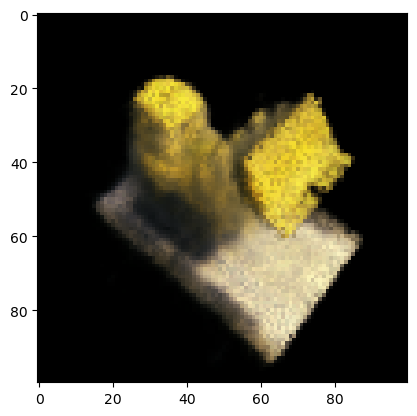

In [51]:
def pose_to_image(
    pose, H, W, focal, t_near, t_far, n_samples, L1, chunk_size, model, device
):
    with torch.no_grad():
        rays_o, rays_d = get_rays(
            H, W, focal, torch.from_numpy(pose).to(device), device=device
        )
        rgb, depth, cls = render_rays(
            model,
            rays_o,
            rays_d,
            t_near,
            t_far,
            n_samples,
            L1,
            chunk_size,
            device=device,
            stratified_sampling=use_stratified_sampling,
        )
    return rgb.detach().cpu().numpy()


model = TinyNeRFSeg("tiny-nerf-seg", L1, n_hidden).to(device)
cp = torch.load("./saved-models/tiny-nerf-seg_version-42/epoch-950/checkpoint.cp")
model.load_state_dict(cp["model_state_dict"])
model.eval()

def transform_pose(pose: np.ndarray, t: np.ndarray=0, rx: np.ndarray=0, ry: np.ndarray=0, rz: np.ndarray=0):
    pose = np.copy(pose)
    pose[:3, 0] += np.array(rx)
    pose[:3, 1] += np.array(ry)
    pose[:3, 2] += np.array(rz)
    pose[:3, 3] += np.array(t)
    return pose


pose = transform_pose(ref_pose, t=(0, 0, 0), rx=(0, 0, 0))
ex_img = pose_to_image(
    pose, H, W, focal, t_near, t_far, n_samples, L1, chunk_size, model, device
)
plt.imshow(ex_img)